In [1]:
from collections import defaultdict, Counter, namedtuple
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
import random
import copy

In [29]:
chroms = [str(x) for x in range(1, 23)]
ihart_family_sizes = [3, 4, 5, 6, 7]
ihart_phase_dir = '../phased_ihart'
ssc_family_sizes = [4]
ssc_phase_dir = '../phased_ssc'

In [3]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [4]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}

chrom_offsets = [0]
for chrom in chroms:
    chrom_offsets.append(chrom_offsets[-1]+chrom_lengths[chrom])
print(chrom_offsets)

[0, 249250621, 492449994, 690472424, 881626700, 1062541960, 1233657027, 1392795690, 1539159712, 1680373143, 1815907890, 1950914406, 2084766301, 2199936179, 2307285719, 2409817111, 2500171864, 2581367074, 2659444322, 2718573305, 2781598825, 2829728720, 2881033286]


# Filter Families


In [5]:
family_to_individuals = dict()

def load_families(phase_dir, family_sizes):
    family_to_chroms = defaultdict(set)
    
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_to_include = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_to_include))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    return families_to_include
ihart_families = load_families(ihart_phase_dir, ihart_family_sizes)
ssc_families = load_families(ssc_phase_dir, ssc_family_sizes)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 880
Counter({22: 880})
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 518
Counter({22: 518})


In [6]:
ihart_individuals = sorted(sum([family_to_individuals[k] for k in ihart_families], []))
ihart_ind_to_index = dict([(x, i) for i, x in enumerate(ihart_individuals)])
ssc_individuals = sorted(sum([family_to_individuals[k] for k in ssc_families], []))
ssc_ind_to_index = dict([(x, i) for i, x in enumerate(ssc_individuals)])

# Read in deletions


In [7]:
Deletion = namedtuple('Deletion', ['family', 'chrom', 'start_pos', 'end_pos', 'length', 'trans', 'notrans', 
                                      'family_size', 'is_mat', 'is_pat'])



In [8]:
from collections import defaultdict

def read_deletions(chrom, phase_dir, family_sizes, families):
    deletions = []

    for j in family_sizes:
            
        # load deletions
        family_to_states = defaultdict(list)
        family_to_pos = defaultdict(list)
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in families:
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    assert end_pos >= start_pos
                        
                    # if a segment is never inherited, we don't know if it has a deletion or not
                    if state[0] == 0 and state[1] == 0:
                        pass
                    else:
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                            state[0] = -1
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                            state[1] = -1
                    if state[2] == 0 and state[3] == 0:
                        pass
                    else:
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                            state[2] = -1
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                            state[3] = -1

                    family_to_states[family_key].append(state)
                    family_to_pos[family_key].append((start_pos, end_pos))

        # for each family, detect deletion transmission
        for family_key, states in family_to_states.items():
            states = np.asarray(states)
            assert np.all(states[0, :4] != 0)
            assert np.all(states[-1, :4] != 0)
            positions = np.asarray(family_to_pos[family_key])
            inds = family_to_individuals[family_key]

            # for each ancestral chromosome
            for anc in range(4):
                is_mat = anc==0 or anc==1
                is_pat = anc==2 or anc==3
                    
                start_indices = np.where((states[:-1, anc] != 0) & (states[1:, anc] == 0))[0]+1
                end_indices = np.where((states[:-1, anc] == 0) & (states[1:, anc] != 0))[0]
                for s_ind, e_ind in zip(start_indices, end_indices):
                    start_pos, end_pos = positions[s_ind, 0], positions[e_ind, 1]
                    state = states[s_ind, :]
                        
                    if (is_mat and np.all(states[s_ind:(e_ind+1), np.arange(4, states.shape[1]-1, 2)] != -1)) \
                    or (is_pat and np.all(states[s_ind:(e_ind+1), np.arange(5, states.shape[1]-1, 2)] != -1)):
                        assert state[-1] != 1

                        for index in range(s_ind, e_ind+1):
                            assert np.all(states[index, 4:] == state[4:])
                        assert start_pos <= end_pos

                        # children
                        trans, notrans = [], []
                        for k, child in zip(range(2, j), inds[2:]):
                            mom_s, dad_s = state[(2*k):(2*(k+1))]

                            if is_mat:
                                assert mom_s != -1
                                if anc==mom_s:
                                    trans.append(child)
                                else:
                                    notrans.append(child)
                            if is_pat:
                                assert dad_s != -1
                                if anc==2+dad_s:
                                    trans.append(child)
                                else:
                                    notrans.append(child)

                        if (len(trans) + len(notrans) == j-2) and (len(trans) > 0):
                            deletions.append(Deletion(family_key, chrom, start_pos, end_pos, end_pos-start_pos+1, 
                                                          tuple(trans), tuple(notrans), j, is_mat, is_pat))
                        
    # sort deletions
    deletions = sorted(deletions, key=lambda x: x.start_pos)
    return deletions



In [9]:
class DeletionCollection:
    def __init__(self, deletion, matches):
        self.deletion = deletion
        self.matches = matches

def create_collections(deletions):
    collections = []
    
    starts = np.array([d.start_pos for d in deletions])
    stops = np.array([d.end_pos for d in deletions])

    ordered_start_indices = np.argsort(starts)
    ordered_starts = starts[ordered_start_indices]
    ordered_stop_indices = np.argsort(stops)
    ordered_stops = stops[ordered_stop_indices]
        
    insert_starts_in_stops = np.searchsorted(ordered_stops, starts)
    insert_stops_in_starts = np.searchsorted(ordered_starts, stops, side='right')
        
    indices = np.ones((len(deletions),), dtype=bool)

    for del_index, main_d in enumerate(deletions):
        indices[:] = True
        indices[ordered_stop_indices[:insert_starts_in_stops[del_index]]] = False
        indices[ordered_start_indices[insert_stops_in_starts[del_index]:]] = False

        collections.append(DeletionCollection(main_d, [deletions[j] for j in np.where(indices)[0]]))
    return collections



In [10]:
def prune_deletions(collections, share_cutoff=0.5):    
    # first, prune deletions that don't overlap with the main deletion by share_cutoff
    for c in collections:
        lengths = np.array([d.length for d in c.matches])
        overlaps = np.array([min(d.end_pos, c.deletion.end_pos)-max(d.start_pos, c.deletion.start_pos)+1 for d in c.matches])
        c.matches = set([c.matches[j] for j in np.where((overlaps >= share_cutoff*lengths) & (overlaps >= share_cutoff*c.deletion.length))[0]])
    return collections

def prune_collections(collections):
        
    deletion_to_index = dict([(x.deletion, i) for i, x in enumerate(collections)])
    
    # now, get rid of collections that are identical to other collections
    for c in collections:
        if c is not None:
            for d in c.matches:
                index = deletion_to_index[d]
                if (c.deletion != d) and (collections[index] is not None) and (c.matches == collections[index].matches):
                    collections[index] = None
    #print('removing %d of %d' % (len([x for x in collections if x is None]), len(collections)))
    collections = [x for x in collections if x is not None]
    return collections





In [14]:
from __future__ import print_function
from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    # From: https://code.activestate.com/recipes/577504/
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)

In [30]:
def generate_chromosomal_collections(chrom, phase_dir, family_sizes, families):
    deletions = read_deletions(chrom, phase_dir, family_sizes, families)
    print('d', end=' ')
    
    collections = create_collections(deletions)
    print('c', end=' ')
    
    collections = prune_deletions(collections)
    print('p', end=' ')
    
    collections = prune_collections(collections)
    print(len(collections), total_size(collections)/1000000)
    
    return collections

In [15]:
#chrom = '1'
#print(chrom, end = ' ')
#
#deletions = read_deletions(chrom, ihart_phase_dir, ihart_family_sizes, ihart_families)
#print('d', end=' ')
#    
#collections = create_collections(deletions)
#print('c', end=' ')
#    
#collections = prune_deletions(collections)
#print('p', end=' ')
#    
#collections = prune_collections(collections)
print(len(collections), total_size(collections)/1000000)

12437 0.807472


In [22]:
ihart_collections = [collections]
chroms = ['1']

In [31]:
ihart_collections = []
for chrom in chroms:
    print(chrom, end=' ')
    ihart_collections.append(generate_chromosomal_collections(chrom, ihart_phase_dir, ihart_family_sizes, ihart_families))
    print()

1 d c p 12437 0.807472

2 d c p 5923 0.380152

3 d c p 6933 0.44968

4 d c p 8391 0.539056

5 d c p 4486 0.289432

6 d c p 15736 1.0218

7 d c p 6954 0.450856

8 d c p 11157 0.723416

9 d c p 17215 1.104624

10 d c p 10117 0.654176

11 d c p 7140 0.461272

12 d c p 5342 0.342192

13 d c p 2449 0.158192

14 d c p 5953 0.381832

15 d c p 3951 0.255184

16 d c p 2064 0.134256

17 d c p 3829 0.248352

18 d c p 1623 0.105568

19 d c p 3726 0.238776

20 d c p 1123 0.073088

21 d c p 3020 0.195856

22 d c p 2327 0.15136



# Modified TDT

In [32]:
cached_pvalue = dict()
ps = [None, None, None] + [pow(2, c-1)/(pow(2, c)-1) for c in range(1, 6)]
print(ps)

def calc_pvalue(trans, notrans, m):
    k = (trans, notrans, m)
    if k not in cached_pvalue:
        cached_pvalue[k] = (scipy.stats.binom_test(trans, trans+notrans, ps[m], alternative='greater'),
                           scipy.stats.binom_test(trans, trans+notrans, ps[m], alternative='less'))
        
    return cached_pvalue[k]

[None, None, None, 1.0, 0.6666666666666666, 0.5714285714285714, 0.5333333333333333, 0.5161290322580645]


In [41]:
def calculate_pvalues(collections, family_sizes, sex, aff):
    pvalues = [np.ones((len(collections[i]), len(family_sizes), 2)) for i in range(len(chroms))]
    num_tests = 0
    familysize_to_index = dict([(x, i) for i, x in enumerate(family_sizes)])
    for i, chrom in enumerate(chroms):
        print(chrom, end=' ')
        for j, c in enumerate(collections[i]):
            if c.deletion.length > 1000:
                trans, notrans = [0]*len(family_sizes), [0]*len(family_sizes)
                for d in c.matches:
                    fam_index = familysize_to_index[d.family_size]
                    a = len([x for x in d.trans if child_id_to_sex[x] == sex and child_id_to_affected[x] == aff])
                    b = len([x for x in d.notrans if child_id_to_sex[x] == sex and child_id_to_affected[x] == aff])
                    #trans[fam_index] += a
                    #notrans[fam_index] += b
                    if a+b > 0:
                        if random.uniform(0, 1) <= a/(a+b):
                            trans[fam_index] += 1
                        else:
                            notrans[fam_index] += 1
                for k, (t, n, s) in enumerate(zip(trans, notrans, family_sizes)):
                    if t+n != 0:
                        pvalues[i][j, k, :] = calc_pvalue(t, n, s)
                        num_tests += 2
                    else:
                        pvalues[i][j, k, :] = np.nan
            else:
                pvalues[i][j, :, :] = np.nan
    return pvalues, num_tests
                        
pvalues_ihart_aff_m, numtests_ihart_aff_m = calculate_pvalues(ihart_collections, ihart_family_sizes, '1', '2')
pvalues_ihart_aff_f, numtests_ihart_aff_f = calculate_pvalues(ihart_collections, ihart_family_sizes, '2', '2')
pvalues_ihart_unaff_m, numtests_ihart_unaff_m = calculate_pvalues(ihart_collections, ihart_family_sizes, '1', '1')
pvalues_ihart_unaff_f, numtests_ihart_unaff_f = calculate_pvalues(ihart_collections, ihart_family_sizes, '2', '1')


pvalues_ssc_aff_m, numtests_ssc_aff_m = calculate_pvalues(ssc_collections, ssc_family_sizes, '1', '2')
pvalues_ssc_aff_f, numtests_ssc_aff_f = calculate_pvalues(ssc_collections, ssc_family_sizes, '2', '2')
pvalues_ssc_unaff_m, numtests_ssc_unaff_m = calculate_pvalues(ssc_collections, ssc_family_sizes, '1', '1')
pvalues_ssc_unaff_f, numtests_ssc_unaff_f = calculate_pvalues(ssc_collections, ssc_family_sizes, '2', '1')
    
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

NameError: name 'ssc_collections' is not defined

In [42]:
def combine_pvalues(pvalues):
    combined_pvalues = [np.ones((pvalues[i].shape[0], 2)) for i in range(len(chroms))]
    for i, chrom in enumerate(chroms):
        print(chrom, end=' ')
        for j in range(pvalues[i].shape[0]):
            indices = ~np.isnan(pvalues[i][j, :, 0])
            if np.sum(indices) > 0:
                combined_pvalues[i][j, 0] = scipy.stats.combine_pvalues(pvalues[i][j, indices, 0], method='fisher')[1]
            indices = ~np.isnan(pvalues[i][j, :, 1])
            if np.sum(indices) > 0:
                combined_pvalues[i][j, 1] = scipy.stats.combine_pvalues(pvalues[i][j, indices, 1], method='fisher')[1]
    return combined_pvalues

pvalues_comb_ihart_aff_m = combine_pvalues(pvalues_ihart_aff_m)
pvalues_comb_ihart_aff_f = combine_pvalues(pvalues_ihart_aff_f)
pvalues_comb_ihart_unaff_m = combine_pvalues(pvalues_ihart_unaff_m)
pvalues_comb_ihart_unaff_f = combine_pvalues(pvalues_ihart_unaff_f)

pvalues_comb_ssc_aff_m = combine_pvalues(pvalues_ssc_aff_m)
pvalues_comb_ssc_aff_f = combine_pvalues(pvalues_ssc_aff_f)
pvalues_comb_ssc_unaff_m = combine_pvalues(pvalues_ssc_unaff_m)
pvalues_comb_ssc_unaff_f = combine_pvalues(pvalues_ssc_unaff_f)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

NameError: name 'pvalues_ssc_aff_m' is not defined

In [43]:
print(np.nanmin(pvalues_ihart_aff_m[0]), np.nanmax(pvalues_ihart_aff_m[0]))
print(np.min(pvalues_comb_ihart_aff_m[0]), np.max(pvalues_comb_ihart_aff_m[0]))

5.373356527294151e-17 1.0
5.405893277941514e-23 1.0


NameError: name 'ssc_collections' is not defined

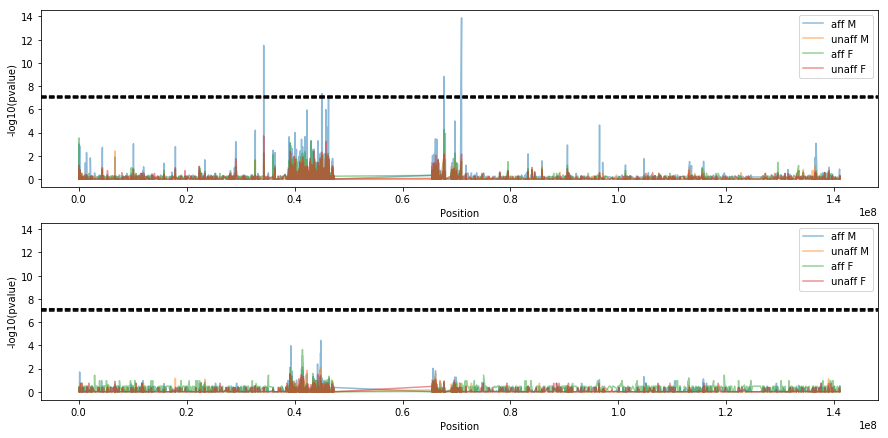

In [52]:
plt.figure(figsize=(15, 15))
  
i = 8
positions = np.array([c.deletion.start_pos for c in ihart_collections[i]])

ax = plt.subplot(4, 1, 1)
plt.plot(positions, -np.log10(pvalues_comb_ihart_aff_m[i][:, 0]), 
            label='aff M', alpha=0.5)
plt.plot(positions, -np.log10(pvalues_comb_ihart_unaff_m[i][:, 0]), 
            label='unaff M', alpha=0.5)
plt.plot(positions, -np.log10(pvalues_comb_ihart_aff_f[i][:, 0]), 
            label='aff F', alpha=0.5)
plt.plot(positions, -np.log10(pvalues_comb_ihart_unaff_f[i][:, 0]), 
            label='unaff F', alpha=0.5)

plt.axhline(-np.log10(0.05/numtests_ihart_aff_m), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ihart_unaff_m), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ihart_aff_f), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ihart_unaff_f), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.legend()

plt.subplot(4, 1, 2, sharey=ax)
plt.plot(positions, -np.log10(pvalues_comb_ihart_aff_m[i][:, 1]), 
            label='aff M', alpha=0.5)
plt.plot(positions, -np.log10(pvalues_comb_ihart_unaff_m[i][:, 1]), 
            label='unaff M', alpha=0.5)
plt.plot(positions, -np.log10(pvalues_comb_ihart_aff_f[i][:, 1]), 
            label='aff F', alpha=0.5)
plt.plot(positions, -np.log10(pvalues_comb_ihart_unaff_f[i][:, 1]), 
            label='unaff F', alpha=0.5)

plt.axhline(-np.log10(0.05/numtests_ihart_aff_m), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ihart_unaff_m), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ihart_aff_f), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ihart_unaff_f), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.legend()

positions = np.array([c.deletion.start_pos for c in ssc_collections[i]])

ax = plt.subplot(4, 1, 3, sharey=ax)
plt.plot(positions, -np.log10(pvalues_comb_ssc_aff_m[i][:, 0]), 
            label='aff M', alpha=0.5)
plt.plot(positions, -np.log10(pvalues_comb_ssc_unaff_m[i][:, 0]), 
            label='unaff M', alpha=0.5)
plt.plot(positions, -np.log10(pvalues_comb_ssc_aff_f[i][:, 0]), 
            label='aff F', alpha=0.5)
plt.plot(positions, -np.log10(pvalues_comb_ssc_unaff_f[i][:, 0]), 
            label='unaff F', alpha=0.5)

plt.axhline(-np.log10(0.05/numtests_ssc_aff_m), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ssc_unaff_m), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ssc_aff_f), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ssc_unaff_f), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.legend()

plt.subplot(4, 1, 4, sharey=ax)
plt.plot(positions, -np.log10(pvalues_comb_ssc_aff_m[i][:, 1]), 
            label='aff M', alpha=0.5)
plt.plot(positions, -np.log10(pvalues_comb_ssc_unaff_m[i][:, 1]), 
            label='unaff M', alpha=0.5)
plt.plot(positions, -np.log10(pvalues_comb_ssc_aff_f[i][:, 1]), 
            label='aff F', alpha=0.5)
plt.plot(positions, -np.log10(pvalues_comb_ssc_unaff_f[i][:, 1]), 
            label='unaff F', alpha=0.5)

plt.axhline(-np.log10(0.05/numtests_ssc_aff_m), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ssc_unaff_m), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ssc_aff_f), linestyle='--', color='black')
plt.axhline(-np.log10(0.05/numtests_ssc_unaff_f), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
cutoff = 8

print('iHART')
x = np.where((-np.log10(pvalues_comb_ihart_aff_m[i][:-1, 0]) < cutoff) & (-np.log10(pvalues_comb_ihart_aff_m[i][1:, 0]) >= cutoff))[0]
y = np.where((-np.log10(pvalues_comb_ihart_aff_m[i][:-1, 0]) >= cutoff) & (-np.log10(pvalues_comb_ihart_aff_m[i][1:, 0]) < cutoff))[0]
for a, b in zip(x, y):
    print(['%s:%d-%d %f' % (chroms[i], ihart_collections[i][j].deletion.start_pos, ihart_collections[i][j].deletion.end_pos, -np.log10(pvalues_comb_ihart_aff_m[i][j, 0])) for j in range(a+1, b+1)])

print('SSC')
x = np.where((-np.log10(pvalues_comb_ssc_aff_m[i][:-1, 0]) < cutoff) & (-np.log10(pvalues_comb_ssc_aff_m[i][1:, 0]) >= cutoff))[0]
y = np.where((-np.log10(pvalues_comb_ssc_aff_m[i][:-1, 0]) >= cutoff) & (-np.log10(pvalues_comb_ssc_aff_m[i][1:, 0]) < cutoff))[0]
for a, b in zip(x, y):
    print(['%s:%d-%d %f' % (chroms[i], ssc_collections[i][j].deletion.start_pos, ssc_collections[i][j].deletion.end_pos, -np.log10(pvalues_comb_ssc_aff_m[i][j, 0])) for j in range(a+1, b+1)])

    

iHART
['9:34273685-34275316 11.511066']
['9:67713908-67721812 8.799214', '9:67715180-67723322 8.379011']
['9:67717846-67723445 8.830587']
['9:70934456-70936761 13.880315']
SSC


NameError: name 'pvalues_comb_ssc_aff_m' is not defined

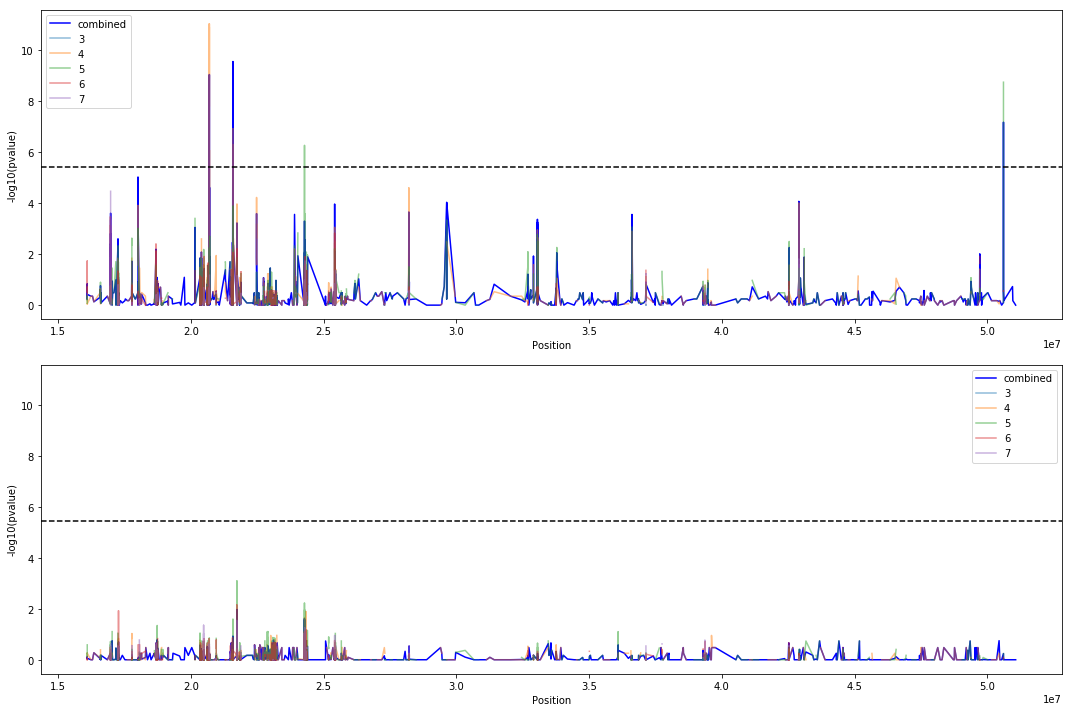

In [26]:
plt.figure(figsize=(15, 10))
  
positions = np.array([c.deletion.start_pos for c in ihart_collections[i]])
indices = np.argsort(positions)

ax = plt.subplot(2, 1, 1)

plt.plot(positions[indices], -np.log10(pvalues_comb_ihart_aff_m[i][indices, 0]), 
            label='combined', color='blue')
for j in range(3, 8):
    plt.plot(positions[indices], -np.log10(pvalues_ihart_aff_m[i][indices, j-3, 0]), 
            label=str(j), alpha=0.5)

plt.axhline(-np.log10(0.05/numtests_ihart_aff_m), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.legend()

plt.subplot(2, 1, 2, sharey=ax)

plt.plot(positions[indices], -np.log10(pvalues_comb_ihart_aff_m[i][indices, 1]), 
            label='combined', color='blue')
for j in range(3, 8):
    plt.plot(positions[indices], -np.log10(pvalues_ihart_aff_m[i][indices, j-3, 1]), 
            label=str(j), alpha=0.5)

plt.axhline(-np.log10(0.05/numtests_ihart_aff_m), linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.legend()

plt.tight_layout()
plt.show()